In [19]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import skorch
import kagglehub
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skorch import NeuralNetBinaryClassifier
from skorch.dataset import ValidSplit
from models import MLPNet
from sklearn.base import BaseEstimator, ClassifierMixin
from time import time

In [2]:
# Download latest version
path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\seanp\.cache\kagglehub\datasets\meruvulikith\190k-spam-ham-email-dataset-for-classification\versions\1


In [3]:
# Checking for GPU availability
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  

True
NVIDIA GeForce RTX 4070 Ti SUPER


In [4]:
# Loading dataset
df = pd.read_csv("spam_Emails_data.csv")

# Dropping rows where label or text is missing
df.dropna(subset=['label', 'text'], inplace=True)

# Printing size of dataset
print(f"Shape of dataset: {df.shape}")

Shape of dataset: (193850, 2)


In [5]:
# Filtering out rows that aren't labeled correctly
df['label'] = df['label'].str.strip().str.lower()
df = df[df['label'].isin(['spam', 'ham'])]

# Encoding labels as binary
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Printing size of dataset
print(f"Shape of dataset: {df.shape}")

Shape of dataset: (193850, 2)


In [6]:
# Creating some features for the dataset

# Email length
df['email_length'] = df['text'].apply(len)

# Number of exclamation points
df['exclamation_points'] = df['text'].str.count('!')

# Number of capital letters
df['capital_letters'] = df['text'].apply(lambda x: sum(1 for c in x.split() if c.isupper()))

# Adding more features here to try and improve performance

# Word count
df['word_count'] = df['text'].str.split().apply(len)

# Puncuation count
df['punctuation_count'] = df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# Digit ratio
df['digit_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isdigit()) / len(x) if len(x) > 0 else 0)

# HTML presence
df['has_html'] = df['text'].str.contains(r'<[^>]+>', regex=True).astype(int)

# URL presence
df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True).astype(int)

# URL count
df['num_urls'] = df['text'].str.count(r'http[s]?://')

# Email count
df['num_emails'] = df['text'].str.count(r'\b[\w.-]+?@\w+?\.\w+?\b')

In [7]:
# Splitting the data into train and test sets BEFORE embedding to prevent data leakage
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['label'])

# Loading pretrained sentence embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2') # experimenting with a few different options here
embedder = embedder.to('cuda')

# Encoding training set and measuring time
start_time = int(time() * 1000)

# Generating embeddings for the training set
embeddings_train = embedder.encode(
    df_train['text'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

end_time = int(time() * 1000)
training_embedder_inference_time = end_time - start_time

print(f"Inference time for SentenceTransformer on training set: {training_embedder_inference_time} ms")

# Encoding test set and measuring time
start_time = int(time() * 1000)

# Generating embeddings for the test set
embeddings_test = embedder.encode(
    df_test['text'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

end_time = int(time() * 1000)
test_embedder_inference_time = end_time - start_time

print(f"Inference time for SentenceTransformer on test set: {test_embedder_inference_time} ms")

# Normalizing and reshaping engineered features
engineered_features = ['email_length', 'exclamation_points', 'capital_letters', 'word_count', 'punctuation_count', 'digit_ratio', 'has_html', 'has_url', 'num_urls', 'num_emails']
scaler = StandardScaler()
engineered_train = scaler.fit_transform(df_train[engineered_features])
engineered_test = scaler.transform(df_test[engineered_features])

# Combining embeddings with engineered features
x_train = np.hstack((embeddings_train, engineered_train))
x_test = np.hstack((embeddings_test, engineered_test))

y_train = df_train['label'].values
y_test = df_test['label'].values

Batches:   0%|          | 0/2424 [00:00<?, ?it/s]

Inference time for SentenceTransformer on training set: 103179 ms


Batches:   0%|          | 0/606 [00:00<?, ?it/s]

Inference time for SentenceTransformer on test set: 24267 ms


In [8]:
# Training several different models and comparing their performance
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Utilizing RandomSearchCV to find optimal parameters for each model
param_random = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }
}

In [9]:
best_models = {}

for name, model in models.items():
    
    print(f"Running RandomSearchCV for {name}")
    random = RandomizedSearchCV(
        model, 
        param_random[name], 
        cv=3, 
        n_iter=10, 
        scoring='f1', 
        verbose=1, 
        n_jobs=-1
    )
    random.fit(x_train, y_train)
    
    best_model = random.best_estimator_
    best_models[name] = best_model
    
    print(f"Best parameters for {name}: {random.best_params_}")
    
    y_pred = best_model.predict(x_test)
    print(f"\n{name} Performance after tuning:\n")
    print(classification_report(y_test, y_pred, digits=4))

Running RandomSearchCV for Logistic Regression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\seanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}

Logistic Regression Performance after tuning:

              precision    recall  f1-score   support

           0     0.9428    0.9420    0.9424     20432
           1     0.9354    0.9363    0.9358     18338

    accuracy                         0.9393     38770
   macro avg     0.9391    0.9391    0.9391     38770
weighted avg     0.9393    0.9393    0.9393     38770

Running RandomSearchCV for Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Random Forest: {'n_estimators': 150, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 20}

Random Forest Performance after tuning:

              precision    recall  f1-score   support

           0     0.9484    0.9674    0.9578     20432
           1     0.9628    0.9414    0.9520     18338

    accuracy                         0.9551     38770
   macro avg     0.9556    0.9544    0.9549     38

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Handling MLP separately with GPU

# Wrapping in skorch for use with PyTorch
net = NeuralNetBinaryClassifier(
    module=MLPNet,
    module__input_dim=x_train.shape[1],
    max_epochs=20,
    train_split=ValidSplit(0.2),
    callbacks=[skorch.callbacks.EarlyStopping(patience=5)],
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)

# Defining randomized search parameters
mlp_param_random = {
    'module__hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'module__dropout': [0.3, 0.5],
    'lr': [0.001, 0.01],
    'max_epochs': [10, 20],
    'batch_size': [32, 64, 128]
}

# Running RandomizedSearchCV on GPU-backed model to search wider range quicker
random = RandomizedSearchCV(net, mlp_param_random, cv=3, n_iter=10, scoring='f1', verbose=1, n_jobs=1)
random.fit(x_train.astype('float32'), y_train.astype('float32'))

best_model = random.best_estimator_
best_models['MLP Neural Net'] = best_model

y_pred = best_model.predict(x_test.astype('float32'))

print(f"Best parameters for MLP Neural Net: {random.best_params_}")
print("\nMLP Neural Net Performance after tuning:\n")
print(classification_report(y_test, y_pred, digits=4))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for MLP Neural Net: {'module__hidden_layer_sizes': (128,), 'module__dropout': 0.5, 'max_epochs': 20, 'lr': 0.001, 'batch_size': 32}

MLP Neural Net Performance after tuning:

              precision    recall  f1-score   support

           0     0.9774    0.9839    0.9807     20432
           1     0.9820    0.9746    0.9783     18338

    accuracy                         0.9795     38770
   macro avg     0.9797    0.9793    0.9795     38770
weighted avg     0.9796    0.9795    0.9795     38770



In [11]:
# Wrapper for skorch model
class SkorchFloat32Wrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, skorch_model):
        self.skorch_model = skorch_model
        self.label_encoder = LabelEncoder()
        self.classes_ = None

    def fit(self, X, y):
        y = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        y = y.astype(np.float32)
        self.skorch_model.fit(X, y)
        return self

    def predict(self, X):
        preds = self.skorch_model.predict(X)
        return self.label_encoder.inverse_transform(preds.astype(int))

    def predict_proba(self, X):
        return self.skorch_model.predict_proba(X)

    def get_params(self, deep=True):
        return {'skorch_model': self.skorch_model}

    def set_params(self, **params):
        self.skorch_model = params['skorch_model']
        return self

# Testing model stacking with the optimal models from above
base_learners = [
    ('lr', best_models['Logistic Regression']),
    ('rf', best_models['Random Forest']),
    ('mlp', SkorchFloat32Wrapper(best_models['MLP Neural Net']))
]

# Using Logistic Regression model as the meta-model
meta_learner = LogisticRegression()

stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
stacked_model.fit(x_train, y_train)

y_pred = stacked_model.predict(x_test)
print("Stacked Model Performance:\n")
print(classification_report(y_test, y_pred, digits=4))

C:\Users\seanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skorch\net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 

Stacked Model Performance:

              precision    recall  f1-score   support

         0.0     0.9803    0.9818    0.9810     20432
         1.0     0.9797    0.9780    0.9788     18338

    accuracy                         0.9800     38770
   macro avg     0.9800    0.9799    0.9799     38770
weighted avg     0.9800    0.9800    0.9800     38770



In [12]:
# Adding stacked model to best_models dictionary
best_models['Stacked Model'] = stacked_model

In [13]:
# Selecting 1000 random samples from the test set
sample_indices = np.random.choice(len(x_test), size=1000, replace=False)
x_sample = x_test[sample_indices]
y_sample = y_test[sample_indices]

# Running 1000 individual predictions for the best models (one at a time)
for model in best_models:
    preds = []
    # Timing predictions
    start_time = int(time() * 1000)
    for i in range(1000):
        pred = best_models[model].predict(x_sample[i].reshape(1, -1))
        preds.append(pred)
    end_time = int(time() * 1000)
    total_time = end_time - start_time
    avg_prediction_time = total_time / 1000
    accuracy = accuracy_score(y_sample, preds) * 100

    print(f"Average prediction time for {model}: {avg_prediction_time:.6f} seconds\n")
    print(f"Accuracy on sample: {accuracy:.2f}%\n")

Average prediction time for Logistic Regression: 0.058000 seconds

Accuracy on sample: 92.60%

Average prediction time for Random Forest: 3.234000 seconds

Accuracy on sample: 95.50%

Average prediction time for MLP Neural Net: 0.699000 seconds

Accuracy on sample: 97.30%

Average prediction time for Stacked Model: 4.156000 seconds

Accuracy on sample: 97.70%



C:\Users\seanp\AppData\Local\Temp\ipykernel_23524\507299977.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette='Blues_d')


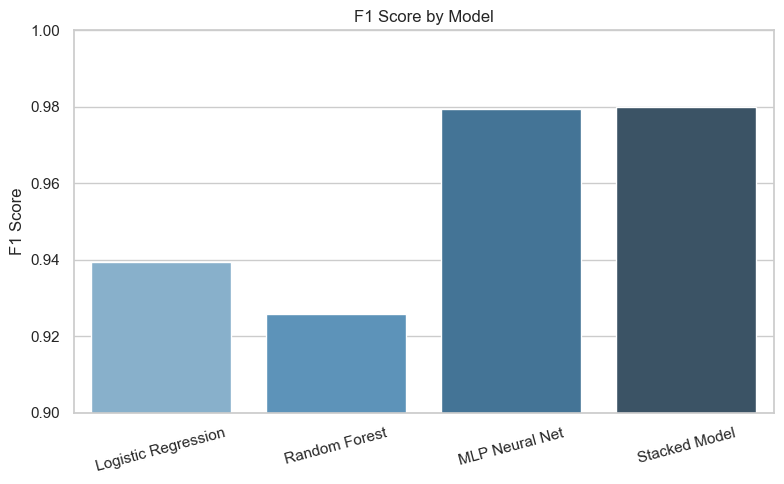

C:\Users\seanp\AppData\Local\Temp\ipykernel_23524\507299977.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='Greens_d')


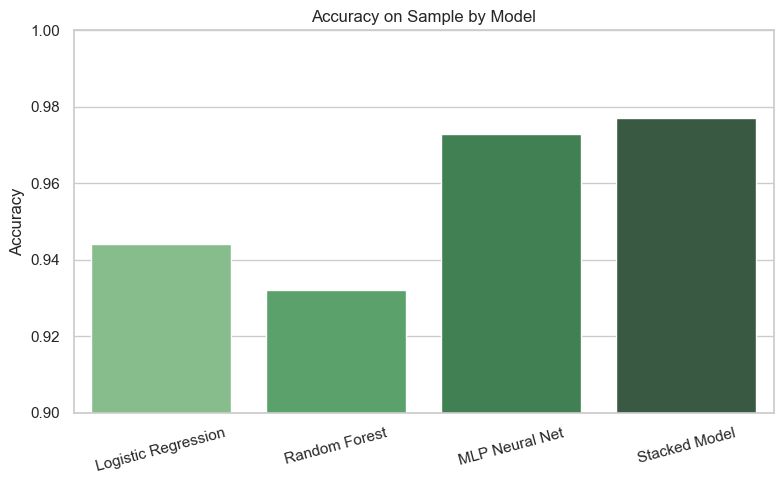

C:\Users\seanp\AppData\Local\Temp\ipykernel_23524\507299977.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=prediction_times, palette='Oranges_d')


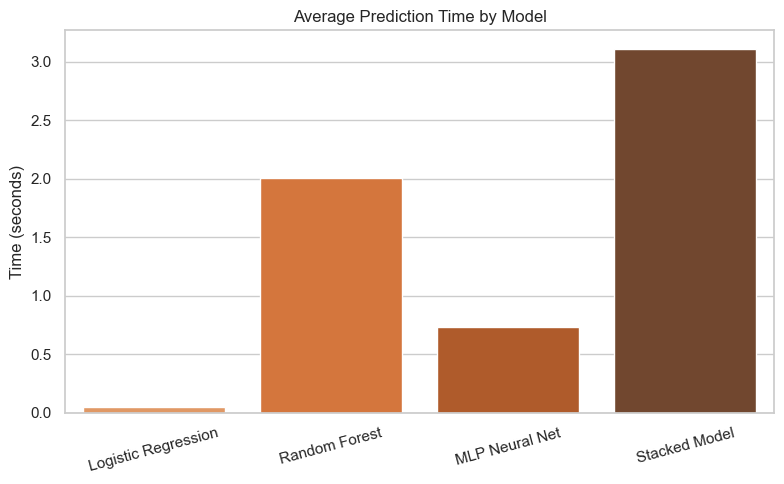

In [15]:
# Making sure plots have consistent style
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 12})

# Model names
model_names = ['Logistic Regression', 'Random Forest', 'MLP Neural Net', 'Stacked Model']

# Corresponding metrics
f1_scores = [0.9393, 0.9259, 0.9795, 0.9800]
accuracies = [0.9440, 0.9320, 0.9730, 0.9770]
prediction_times = [0.050, 2.008, 0.736, 3.113]

# Bar chart: F1 Score
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f1_scores, palette='Blues_d')
plt.title('F1 Score by Model')
plt.ylabel('F1 Score')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Bar chart: Accuracy
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='Greens_d')
plt.title('Accuracy on Sample by Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Bar chart: Prediction Time
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=prediction_times, palette='Oranges_d')
plt.title('Average Prediction Time by Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [20]:
# Saving models for future use
for model in best_models:
    joblib.dump(best_models[model], f'{model}.pkl')